## Lab 2
**Author :** ***Ahmed Samady***\
**Supervised by :** ***Pr. Lotfi El Aachak***\
**Course :** ***NLP***

### Imports

In [1]:
import json
import re
import string
from nltk.tokenize import word_tokenize
from word2number import w2n
from nltk.corpus import stopwords
import pyarabic.araby as araby
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec
from gensim.models import fasttext
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
import arabic_reshaper

## Part 1: Rule based NLP and RegEx

#### The Sentences that we will be working on

In [2]:
text1 = "I bought three Samsung smartphones 150 $ each, four kilos of fresh banana for 1,2 dollar a kilogram and one Hamburger with 4,5 dollar"
text2 = "I purchased four Apple iPhones 200 $ each, two million and five hundred thousand eggs for 0,1 dollars per egg, and one sandwich for 6.99$."
text3 = "He bought one Sony TV for 300 dollars, five bags of rice at 2.99 dollar per kilogram, and one pizzas for 12,14 dollars each. and twenty chocolate bars for 0.99 dollars a bar."

#### Defining the RegEx for extracting number of items, product names, and prices

In [3]:
number_list = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine',
                'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen',
                'seventeen', 'eighteen', 'nineteen', 'twenty', 'thirty', 'forty', 'fifty',
                'sixty', 'seventy', 'eighty', 'ninety', 'hundred', 'thousand', 'million',
                'billion', 'trillion']
def get_bill_items(text):
    
    nb_prod_pattern = r"(?:\s)(?:" + "|".join(number_list) + r")(?:\s(?:" + "|".join(number_list) + r"|and))*"
    price_pattern = r"(\d+(?:\,|\.)?\d*)\s*(?:\$|dollar)"
    product_pattern = r"(?:\b(?:" + "|".join(number_list) + r")\b)" + r"(.+?)" + r"(?:(?:\d*(?:\,|\.)?\d*)\s*(?:\$|dollar))"
    
    nb_prod_matches = re.findall(nb_prod_pattern,text)
    price_matches = re.findall(price_pattern,text)
    product_matches = re.findall(product_pattern,text)
    
    return nb_prod_matches, price_matches, product_matches

#### Testing whether the Regular Expressions correctly identify the patterns intended to extract from the sentences

In [4]:
t1_nb_prod, t1_prices, t1_products = get_bill_items(text1)
t2_nb_prod, t2_prices, t2_products = get_bill_items(text2)
t3_nb_prod, t3_prices, t3_products = get_bill_items(text3)

print(t1_nb_prod,t1_prices,t1_products)
print(t2_nb_prod,t2_prices,t2_products)
print(t3_nb_prod,t3_prices,t3_products)

[' three', ' four', ' one'] ['150', '1,2', '4,5'] [' Samsung smartphones ', ' kilos of fresh banana for ', ' Hamburger with ']
[' four', ' two million and five hundred thousand', ' one'] ['200', '0,1', '6.99'] [' Apple iPhones ', ' million and five hundred thousand eggs for ', ' sandwich for ']
[' one', ' five', ' one', ' twenty'] ['300', '2.99', '12,14', '0.99'] [' Sony TV for ', ' bags of rice at ', ' pizzas for ', ' chocolate bars for ']


#### Defining a function to print out the bill:
The function also removes stopwords, the variants of the word `Kilogram`, and word numbers in plain English

In [5]:
def print_bill(nb_prod_matches, price_matches, product_matches):
    kg_variants = ['kilogram', 'kilograms', 'kg', 'kgs', 'kilo', 'kilos', 'k', 'g', 'gram', 'grams']
    bill_items = []
    for i in range(len(nb_prod_matches)):
        price_matches[i] = price_matches[i].replace(",", ".")
        product_matches[i] = product_matches[i].strip()
        product_matches[i] = ' '.join([word for word in word_tokenize(product_matches[i]) if word not in stopwords.words('english')])
        product_matches[i] = ' '.join([word for word in word_tokenize(product_matches[i]) if word not in kg_variants])
        product_matches[i] = ' '.join([word for word in word_tokenize(product_matches[i]) if word not in number_list])
        item = {
            "Product": product_matches[i],
            "Quantity": w2n.word_to_num(nb_prod_matches[i]),
            "Unit Price": price_matches[i],
            "Total Price": (w2n.word_to_num(nb_prod_matches[i]) * float(price_matches[i])).__round__(2)
        }
        bill_items.append(item)
    bill_string = "| {:<40} | {:>8} | {:>12} | {:>20} |\n".format(
        "Product", "Quantity", "Unit Price", "Total Price")
    bill_string += "-" * 93 + "\n"

    for item in bill_items:
        bill_string += "| {:<40} | {:>8} | {:>12} | {:>20} |\n".format(
            item["Product"], item["Quantity"], item["Unit Price"], item["Total Price"])

    bill_string += "-" * 93 + "\n"
    return bill_string

#### Test on the 1st sentence

In [6]:
bill1 = print_bill(t1_nb_prod, t1_prices, t1_products)
print(bill1)

| Product                                  | Quantity |   Unit Price |          Total Price |
---------------------------------------------------------------------------------------------
| Samsung smartphones                      |        3 |          150 |                450.0 |
| fresh banana                             |        4 |          1.2 |                  4.8 |
| Hamburger                                |        1 |          4.5 |                  4.5 |
---------------------------------------------------------------------------------------------



#### Test on the 2nd sentence

In [7]:
bill2 = print_bill(t2_nb_prod, t2_prices, t2_products)
print(bill2)

| Product                                  | Quantity |   Unit Price |          Total Price |
---------------------------------------------------------------------------------------------
| Apple iPhones                            |        4 |          200 |                800.0 |
| eggs                                     |  2501500 |          0.1 |             250150.0 |
| sandwich                                 |        1 |         6.99 |                 6.99 |
---------------------------------------------------------------------------------------------



#### Test on the 3rd sentence

In [8]:
bill3 = print_bill(t3_nb_prod, t3_prices, t3_products)
print(bill3)

| Product                                  | Quantity |   Unit Price |          Total Price |
---------------------------------------------------------------------------------------------
| Sony TV                                  |        1 |          300 |                300.0 |
| bags rice                                |        5 |         2.99 |                14.95 |
| pizzas                                   |        1 |        12.14 |                12.14 |
| chocolate bars                           |       20 |         0.99 |                 19.8 |
---------------------------------------------------------------------------------------------



## Part 2: Word Embeddings

#### Loading the contents of the first article from Lab-1

In [9]:
with open('..\Lab1\data\hess_article_content.json', 'r', encoding='utf-8') as f:
    art_content = json.load(f)
text = art_content[0]['content']
text.encode('utf-8')
print("Raw text: ",text)

Raw text:  أنهت أسعار العقود الآجلة للذهب تعاملات اليوم الأربعاء بتراجع ملموس بعد ارتفاعها ثلاثة أيام على التوالي، حيث تضرر المعدن الأصفر من ارتفاع الدولار على خلفية ارتفاع أسعار المستهلك في الولايات المتحدة بأكثر من التوقعات، مما يقلل احتمالات خفض الفائدة الأمريكية قريبا.وبعد إعلان بيانات التضخم، اليوم، تراجعت فرص خفض الفائدة الأمريكية خلال يونيو المقبل إلى 15,1 بالمئة فقط وفقا لمؤشر مراقبة مجلس الاحتياط الاتحادي.وارتفع مؤشر قيمة الدولار أمام العملات الرئيسية إلى 105,30 نقطة، قبل أن يقلص مكاسبه ليسجل 105,20 نقطة في تعاملات الظهيرة بارتفاع قدره نقطة مئوية تقريبا عن مستواه أمس.وارتفع سعر المعدن الأصفر بمقدار 13,9 دولارات، بنسبة 0,6 بالمئة إلى 2329,60 دولارا للأوقية تسليم أبريل الحالي.كما ارتفع سعر الفضة بمقدار 0,070 دولارا، بنسبة 0,215 بالمئة إلى 25,961 دولارا للأوقية تسليم أبريل الحالي.وأظهرت بيانات وزارة العمل الأمريكية، الصادرة اليوم الأربعاء، ارتفاع مؤشر أسعار المستهلك في الولايات المتحدة خلال الشهر الماضي بأكثر من التوقعات نتيجة ارتفاع أسعار المسكن والوقود.وذكرت الوزارة أن أسعار ال

#### Tokenizing text to sentences and words

In [10]:
corpus = araby.sentence_tokenize(text)
print(f"Tokenized sentences: {corpus}")

Tokenized sentences: ['أنهت أسعار العقود الآجلة للذهب تعاملات اليوم الأربعاء بتراجع ملموس بعد ارتفاعها ثلاثة أيام على التوالي،', 'حيث تضرر المعدن الأصفر من ارتفاع الدولار على خلفية ارتفاع أسعار المستهلك في الولايات المتحدة بأكثر من التوقعات،', 'مما يقلل احتمالات خفض الفائدة الأمريكية قريبا.وبعد إعلان بيانات التضخم،', 'اليوم،', 'تراجعت فرص خفض الفائدة الأمريكية خلال يونيو المقبل إلى 15,1 بالمئة فقط وفقا لمؤشر مراقبة مجلس الاحتياط الاتحادي.وارتفع مؤشر قيمة الدولار أمام العملات الرئيسية إلى 105,30 نقطة،', 'قبل أن يقلص مكاسبه ليسجل 105,20 نقطة في تعاملات الظهيرة بارتفاع قدره نقطة مئوية تقريبا عن مستواه أمس.وارتفع سعر المعدن الأصفر بمقدار 13,9 دولارات،', 'بنسبة 0,6 بالمئة إلى 2329,60 دولارا للأوقية تسليم أبريل الحالي.كما ارتفع سعر الفضة بمقدار 0,070 دولارا،', 'بنسبة 0,215 بالمئة إلى 25,961 دولارا للأوقية تسليم أبريل الحالي.وأظهرت بيانات وزارة العمل الأمريكية،', 'الصادرة اليوم الأربعاء،', 'ارتفاع مؤشر أسعار المستهلك في الولايات المتحدة خلال الشهر الماضي بأكثر من التوقعات نتيجة ارتفاع أسعار ا

#### Creating a set of unique words from the corpus

In [11]:
ar_punct = ''')(+`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”،.”…“–ـ”.'''
en_punct = string.punctuation
punct_lst = ar_punct + en_punct
unique_words = set()
for sentence in corpus:
    for word in araby.tokenize(sentence):
        if word not in stopwords.words('arabic') and word not in punct_lst and word.isdigit() == False:
            unique_words.add(word)
print(f"Unique words: {unique_words}")
print(f"Number of unique words: {len(unique_words)}")

Unique words: {'وارتفع', 'وذكرت', 'العملات', 'المعدن', 'أسعار', 'والوقود', 'المتحدة', 'قدره', 'ملموس', 'وبعد', 'الوزارة', 'الأمريكية', 'المحللون', 'الأصفر', 'شهريا', 'الزيادة', 'الظهيرة', 'قيمة', 'وعلى', 'الدولار', 'فرص', 'التوالي', 'تقلبا', 'بلغ', 'بالمئة', 'نفسها', 'نفسه', 'المسجلة', 'يقلل', 'بتراجع', 'للأوقية', 'إعلان', 'سنوي', 'يتوقعون', 'الغذاء', 'فقط', 'قريبا', 'ارتفعت', 'خلال', 'الأساسي', 'بمقدار', 'بنسبة', 'العقود', 'سنويا', 'أيام', 'الفضة', 'احتمالات', 'خفض', 'أساس', 'وزارة', 'مستواه', 'السابق', 'الفائدة', 'مراقبة', 'ارتفع', 'وأظهرت', 'تسليم', 'معدل', 'الشهر', 'العمل', 'ارتفاعها', 'نتيجة', 'الأشد', 'مكاسبه', 'مئوية', 'تضرر', 'تعاملات', 'التوقعات', 'التضخم', 'مؤشر', 'تراجعه', 'والطاقة', 'أنهت', 'للذهب', 'وفقا', 'الرئيسية', 'ليسجل', 'الثالث', 'الآجلة', 'الأربعاء', 'يقلص', 'الاحتياط', 'الوقت', 'دولارات', 'تراجعت', 'الماضي', 'لمؤشر', 'ارتفاع', 'للشهر', 'ارتفاعه', 'تقريبا', 'وهي', 'الصادرة', 'اليوم', 'يستبعد', 'سعر', 'السلع', 'المسكن', 'خلفية', 'نقطة', 'الحالي', 'بأكثر', 'دولارا', 

### 1.1. One-Hot-Encoding

In [12]:
one_hot_encoded = []
for word in unique_words:
    encoding = np.zeros(len(unique_words))
    
    index = list(unique_words).index(word)
    
    encoding[index] = 1
    one_hot_encoded.append((word, encoding))
    
df_onehot = pd.DataFrame(one_hot_encoded, columns=['Word', 'One-hot encoding'])
df_onehot

,Word,One-hot encoding
0,وارتفع,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,وذكرت,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,العملات,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,المعدن,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,أسعار,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
105,بارتفاع,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
106,الاتحادي,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
107,مجلس,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
108,بيانات,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### 1.2. Bag of Words

In [13]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
df_BoW = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())
df_BoW.head()

,070,105,13,15,20,215,2329,25,30,60,...,وزارة,وعلى,وفقا,وهو,وهي,يتوقعون,يستبعد,يقلص,يقلل,يونيو
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


### 1.3. TF-IDF

In [14]:
tr_idf_model  = TfidfVectorizer()
tf_idf_vector = tr_idf_model.fit_transform(corpus)
tf_idf_array = tf_idf_vector.toarray()
df_tf_idf = pd.DataFrame(tf_idf_array, columns = tr_idf_model.get_feature_names_out())
df_tf_idf.head()

,070,105,13,15,20,215,2329,25,30,60,...,وزارة,وعلى,وفقا,وهو,وهي,يتوقعون,يستبعد,يقلص,يقلل,يونيو
0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.321352,0.000000
3,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.17326,0.0,0.197945,0.0,0.0,0.0,0.0,0.197945,0.0,...,0.0,0.0,0.197945,0.0,0.0,0.0,0.0,0.0,0.000000,0.197945


### 2. Word2Vec

In [15]:
tokenized_corpus = []
for sentence in corpus:
    tokenized_sentence = [word for word in araby.tokenize(sentence) if (word not in stopwords.words('arabic')) and (word.isdigit() == False) and (word not in ['.', ',', '!', '?', ':', ';', '،', '؟', '؛'])]
    tokenized_corpus.append(tokenized_sentence)

In [34]:
print(f"Tokenized corpus: {tokenized_corpus}")

Tokenized corpus: [['أنهت', 'أسعار', 'العقود', 'الآجلة', 'للذهب', 'تعاملات', 'اليوم', 'الأربعاء', 'بتراجع', 'ملموس', 'ارتفاعها', 'أيام', 'التوالي'], ['تضرر', 'المعدن', 'الأصفر', 'ارتفاع', 'الدولار', 'خلفية', 'ارتفاع', 'أسعار', 'المستهلك', 'الولايات', 'المتحدة', 'بأكثر', 'التوقعات'], ['يقلل', 'احتمالات', 'خفض', 'الفائدة', 'الأمريكية', 'قريبا', 'وبعد', 'إعلان', 'بيانات', 'التضخم'], ['اليوم'], ['تراجعت', 'فرص', 'خفض', 'الفائدة', 'الأمريكية', 'خلال', 'المقبل', 'بالمئة', 'فقط', 'وفقا', 'لمؤشر', 'مراقبة', 'مجلس', 'الاحتياط', 'الاتحادي', 'وارتفع', 'مؤشر', 'قيمة', 'الدولار', 'العملات', 'الرئيسية', 'نقطة'], ['يقلص', 'مكاسبه', 'ليسجل', 'نقطة', 'تعاملات', 'الظهيرة', 'بارتفاع', 'قدره', 'نقطة', 'مئوية', 'تقريبا', 'مستواه', 'وارتفع', 'سعر', 'المعدن', 'الأصفر', 'بمقدار', 'دولارات'], ['بنسبة', 'بالمئة', 'دولارا', 'للأوقية', 'تسليم', 'الحالي', 'ارتفع', 'سعر', 'الفضة', 'بمقدار', 'دولارا'], ['بنسبة', 'بالمئة', 'دولارا', 'للأوقية', 'تسليم', 'الحالي', 'وأظهرت', 'بيانات', 'وزارة', 'العمل', 'الأمريكية'], ['ا

#### 2.1. CBoW
#### Training The CBoW Model on the corpus data

In [16]:
cbow_w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=100, window=30,
                            min_count=1, sample=1e-3, sg=0, epochs=1000)

#### Finding the top 5 most similar words to each word in the corpus according to the CBoW Model

In [17]:
similar_words = {search_term : [item[0] for item in cbow_w2v_model.wv.most_similar([search_term], topn=5)] for search_term in 
               cbow_w2v_model.wv.key_to_index}
similar_words

{'بالمئة': ['بنسبة', 'المحللون', 'يتوقعون', 'تراجعه', 'سنويا'],
 'بنسبة': ['بالمئة', 'وعلى', 'المحللون', 'ارتفاعه', 'أساس'],
 'أسعار': ['المستهلك', 'نتيجة', 'المسكن', 'الوزارة', 'والوقود'],
 'خلال': ['الماضي', 'الشهر', 'وذكرت', 'الوزارة', 'مؤشر'],
 'المستهلك': ['المتحدة', 'أسعار', 'الولايات', 'الوزارة', 'المسكن'],
 'الماضي': ['ارتفعت', 'الشهر', 'الوزارة', 'وذكرت', 'خلال'],
 'الشهر': ['يتوقعون', 'المحللون', 'الماضي', 'خلال', 'سنويا'],
 'ارتفاع': ['بأكثر', 'التوقعات', 'نتيجة', 'المتحدة', 'المستهلك'],
 'المحللون': ['يتوقعون', 'تراجعه', 'الشهر', 'بالمئة', 'سنويا'],
 'يتوقعون': ['المحللون', 'تراجعه', 'الشهر', 'سنويا', 'الأساسي'],
 'ارتفاعها': ['الأساسي', 'الوقت', 'سنويا', 'بلغ', 'معدل'],
 'نقطة': ['ليسجل', 'الظهيرة', 'قدره', 'بارتفاع', 'يقلص'],
 'الولايات': ['المتحدة', 'المستهلك', 'ارتفعت', 'التوقعات', 'ارتفاع'],
 'شهريا': ['أسعار', 'المسكن', 'الوزارة', 'وذكرت', 'المستهلك'],
 'الأمريكية': ['خفض', 'الفائدة', 'بيانات', 'احتمالات', 'يقلل'],
 'المتحدة': ['الولايات', 'المستهلك', 'التوقعات', 'ارت

#### Testing the similarity between the two words `الحالي` and `الماضي` for CBoW

In [35]:
vec1 = cbow_w2v_model.wv.get_vector('الحالي')
vec2 = cbow_w2v_model.wv.get_vector('الماضي')
similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
print(f"similarity between the two words `الحالي` and `الماضي` using the CBoW model is : {similarity}")

similarity between the two words `الحالي` and `الماضي` using the CBoW model is : 0.16123710572719574


#### 2.2. Skip Gram
#### Training The Skip Gram Model on the corpus data

In [19]:
sg_w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=100, window=30,
                            min_count=1, sample=1e-3, sg=1, epochs=1000)

#### Finding the top 5 most similar words to each word in the corpus according to the Skip Gram Model

In [20]:
similar_words = {search_term : [item[0] for item in sg_w2v_model.wv.most_similar([search_term], topn=5)] for search_term in 
               sg_w2v_model.wv.key_to_index}
similar_words

{'بالمئة': ['بنسبة', 'خلال', 'يتوقعون', 'المحللون', 'مؤشر'],
 'بنسبة': ['بالمئة', 'الشهر', 'شهريا', 'المحللون', 'ارتفعت'],
 'أسعار': ['المستهلك', 'المتحدة', 'ارتفعت', 'الولايات', 'التوقعات'],
 'خلال': ['مؤشر', 'بالمئة', 'الشهر', 'يتوقعون', 'المحللون'],
 'المستهلك': ['المتحدة', 'الولايات', 'ارتفعت', 'بأكثر', 'التوقعات'],
 'الماضي': ['الشهر', 'ارتفعت', 'نتيجة', 'يتوقعون', 'المسكن'],
 'الشهر': ['الماضي', 'ارتفعت', 'المحللون', 'يتوقعون', 'السابق'],
 'ارتفاع': ['التوقعات', 'بأكثر', 'الوزارة', 'المسكن', 'وذكرت'],
 'المحللون': ['يتوقعون', 'تراجعه', 'الأساسي', 'سنويا', 'سنوي'],
 'يتوقعون': ['المحللون', 'تراجعه', 'الأساسي', 'سنويا', 'سنوي'],
 'ارتفاعها': ['معدل', 'الأساسي', 'الوقت', 'بلغ', 'سنويا'],
 'نقطة': ['وارتفع', 'مئوية', 'تقريبا', 'مكاسبه', 'يقلص'],
 'الولايات': ['المتحدة', 'المستهلك', 'ارتفعت', 'بأكثر', 'التوقعات'],
 'شهريا': ['ارتفعت', 'الوزارة', 'والوقود', 'وذكرت', 'نتيجة'],
 'الأمريكية': ['خفض', 'الفائدة', 'بيانات', 'فقط', 'لمؤشر'],
 'المتحدة': ['الولايات', 'المستهلك', 'ارتفعت', 'بأك

#### Testing the similarity between the two words `الحالي` and `الماضي` for Skip Gram

In [37]:
vec1 = sg_w2v_model.wv.get_vector('الحالي')
vec2 = sg_w2v_model.wv.get_vector('الماضي')
similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
print(f"similarity between the two words `الحالي` and `الماضي` using the Word2Vec Skip Gram model is : {similarity}")

similarity between the two words `الحالي` and `الماضي` using the Word2Vec Skip Gram model is : 0.18647247552871704


### 3.1. FastText
#### Training The FastText Model on the corpus data

In [23]:
fasttext_model = fasttext.FastText(tokenized_corpus, vector_size=100, window=30,
                            min_count=1, sample=1e-3, sg=0, epochs=1000)

#### Finding the top 5 most similar words to each word in the corpus according to the FastText Model

In [24]:
similar_words = {search_term : [item[0] for item in fasttext_model.wv.most_similar([search_term], topn=5)] for search_term in 
               fasttext_model.wv.key_to_index}
similar_words

{'بالمئة': ['بنسبة', 'يتوقعون', 'المحللون', 'سنوي', 'سنويا'],
 'بنسبة': ['بالمئة', 'سنوي', 'وعلى', 'أساس', 'يتوقعون'],
 'أسعار': ['المستهلك', 'التوقعات', 'المتحدة', 'الولايات', 'نتيجة'],
 'خلال': ['الماضي', 'المحللون', 'الشهر', 'الوقت', 'يتوقعون'],
 'المستهلك': ['المتحدة', 'المسكن', 'الولايات', 'أسعار', 'نتيجة'],
 'الماضي': ['خلال', 'المسكن', 'المستهلك', 'المتحدة', 'وذكرت'],
 'الشهر': ['المحللون', 'يتوقعون', 'الوقت', 'خلال', 'سنوي'],
 'ارتفاع': ['ارتفاعه', 'الولايات', 'أسعار', 'المتحدة', 'ارتفعت'],
 'المحللون': ['يتوقعون', 'الشهر', 'خلال', 'الوقت', 'سنوي'],
 'يتوقعون': ['المحللون', 'الشهر', 'سنوي', 'سنويا', 'الوقت'],
 'ارتفاعها': ['ارتفاعه', 'يتوقعون', 'الشهر', 'المحللون', 'أساس'],
 'نقطة': ['الظهيرة', 'مئوية', 'ليسجل', 'قدره', 'يقلص'],
 'الولايات': ['المتحدة', 'المستهلك', 'أسعار', 'التوقعات', 'ارتفعت'],
 'شهريا': ['والوقود', 'الماضي', 'الثالث', 'الشهر', 'الوزارة'],
 'الأمريكية': ['خفض', 'الفائدة', 'العمل', 'احتمالات', 'بيانات'],
 'المتحدة': ['الولايات', 'المستهلك', 'التوقعات', 'المسكن

#### Testing the similarity between the two words `الحالي` and `الماضي` for FastText

In [39]:
vec1 = fasttext_model.wv.get_vector('الحالي')
vec2 = fasttext_model.wv.get_vector('الماضي')
similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
print(f"similarity between the two words `الحالي` and `الماضي` using the FastText CBoW model is : {similarity}")

similarity between the two words `الحالي` and `الماضي` using the FastText CBoW model is : 0.16581687331199646


### 3.2. GloVe
#### Loading the pre-trained Arabic GloVe Model

In [26]:
glove_model = KeyedVectors.load_word2vec_format('.vector_cache/vectors.txt', encoding='utf-8', no_header=True)

#### Testing the similarity between the two words `الحالي` and `الماضي` using the pre-trained Arabic GloVe Model

In [46]:
vec1 = glove_model['الحالي']
vec2 = glove_model['الماضي']
similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
print(f"similarity between the two words `الحالي` and `الماضي` using the pre-trained GloVe model is : {similarity}")

similarity between the two words `الحالي` and `الماضي` using the pre-trained GloVe model is : 0.650802493095398


#### Saving the vectors of the corpus words that exist in the pretrained model to a list

In [45]:
glove_vectors = []
glove_words = []
non = []
for word in unique_words:
    try:
        glove_vectors.append(glove_model[word])
        glove_words.append(word)
    except KeyError:
        print(f"{word} is not in the vocabulary")

أسعار is not in the vocabulary
الأمريكية is not in the vocabulary
الأصفر is not in the vocabulary
للأوقية is not in the vocabulary
إعلان is not in the vocabulary
الأساسي is not in the vocabulary
أيام is not in the vocabulary
أساس is not in the vocabulary
وأظهرت is not in the vocabulary
الأشد is not in the vocabulary
أنهت is not in the vocabulary
الآجلة is not in the vocabulary
الأربعاء is not in the vocabulary
بأكثر is not in the vocabulary


### 4. Plotting the vectors using t-SNE

#### 4.1. One-hot Encoding

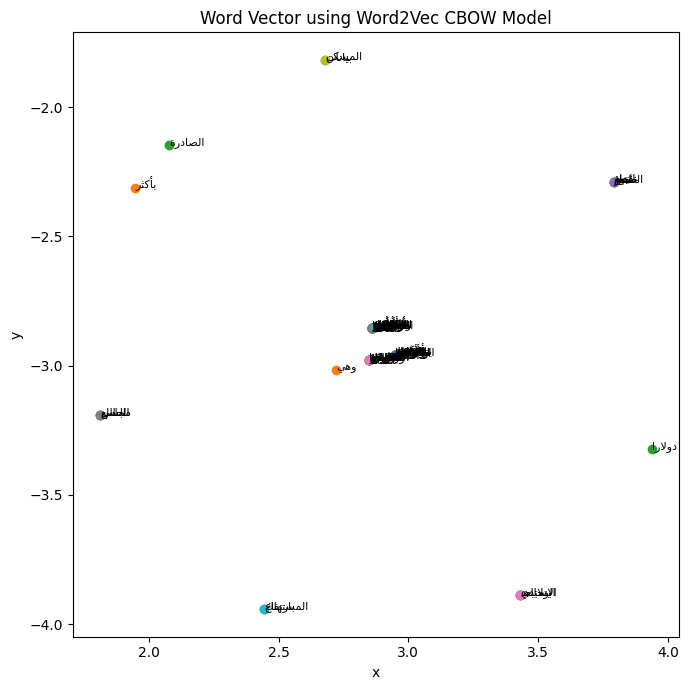

In [29]:
words = df_onehot['Word']
vectors = np.asarray(df_onehot['One-hot encoding'].to_list())

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, n_iter_without_progress=500)
vectors_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(7, 7))
for i, word in enumerate(words):
    xxword = arabic_reshaper.reshape(word) # support arabic letters
    xxartext = get_display(xxword)
    plt.scatter(vectors_2d[i][0], vectors_2d[i][1], marker='o')
    plt.annotate(xxartext, xy=(vectors_2d[i][0], vectors_2d[i][1]), fontsize=8)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Word Vector using Word2Vec CBOW Model')
plt.tight_layout()
plt.show()

#### 4.2. CBoW

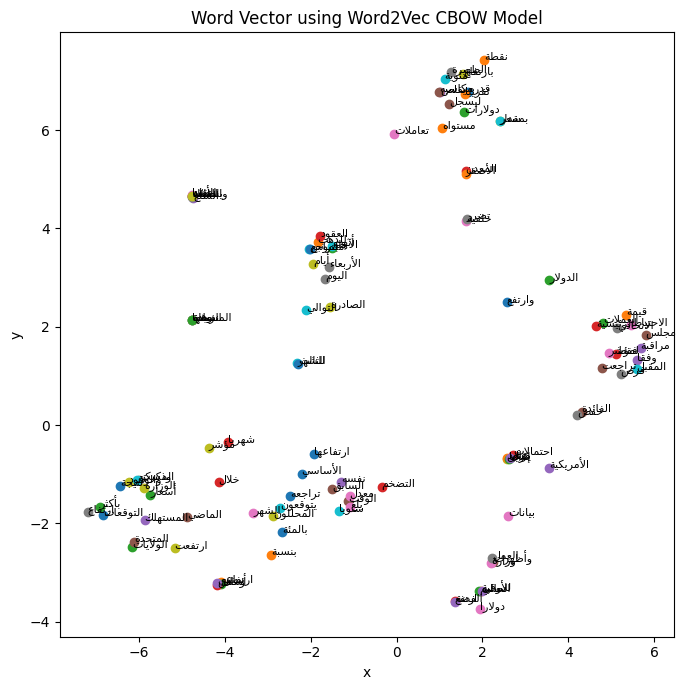

In [30]:
words = list(cbow_w2v_model.wv.index_to_key)
vectors = cbow_w2v_model.wv.vectors

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, n_iter_without_progress=500)
vectors_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(7, 7))
for i, word in enumerate(words):
    xxword = arabic_reshaper.reshape(word) # support arabic letters
    xxartext = get_display(xxword)
    plt.scatter(vectors_2d[i][0], vectors_2d[i][1], marker='o')
    plt.annotate(xxartext, xy=(vectors_2d[i][0], vectors_2d[i][1]), fontsize=8)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Word Vector using Word2Vec CBOW Model')
plt.tight_layout()
plt.show()

#### 4.3. Skip Gram

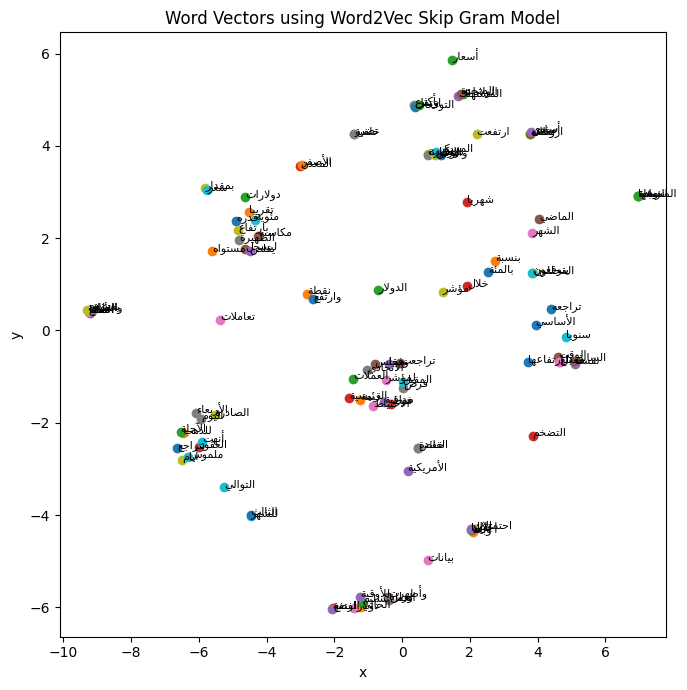

In [31]:
words = list(sg_w2v_model.wv.index_to_key)
vectors = sg_w2v_model.wv.vectors

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, n_iter_without_progress=500)
vectors_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(7, 7))
for i, word in enumerate(words):
    xxword = arabic_reshaper.reshape(word) # support arabic letters
    xxartext = get_display(xxword)
    plt.scatter(vectors_2d[i][0], vectors_2d[i][1], marker='o')
    plt.annotate(xxartext, xy=(vectors_2d[i][0], vectors_2d[i][1]), fontsize=8)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Word Vectors using Word2Vec Skip Gram Model')
plt.tight_layout()
plt.show()

#### 4.4. FastText

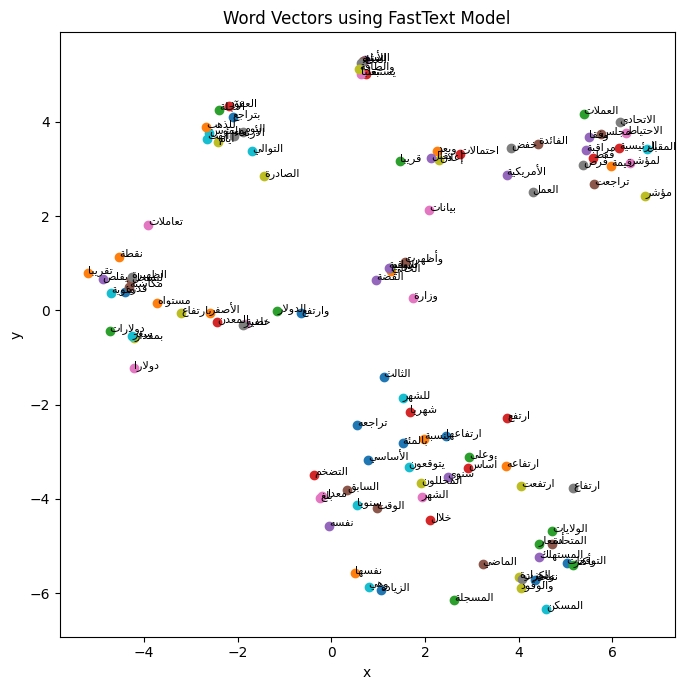

In [32]:
words = list(fasttext_model.wv.index_to_key)
vectors = fasttext_model.wv.vectors

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, n_iter_without_progress=500)
vectors_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(7, 7))
for i, word in enumerate(words):
    xxword = arabic_reshaper.reshape(word) # support arabic letters
    xxartext = get_display(xxword)
    plt.scatter(vectors_2d[i][0], vectors_2d[i][1], marker='o')
    plt.annotate(xxartext, xy=(vectors_2d[i][0], vectors_2d[i][1]), fontsize=8)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Word Vectors using FastText Model')
plt.tight_layout()
plt.show()

#### 4.5. GloVe

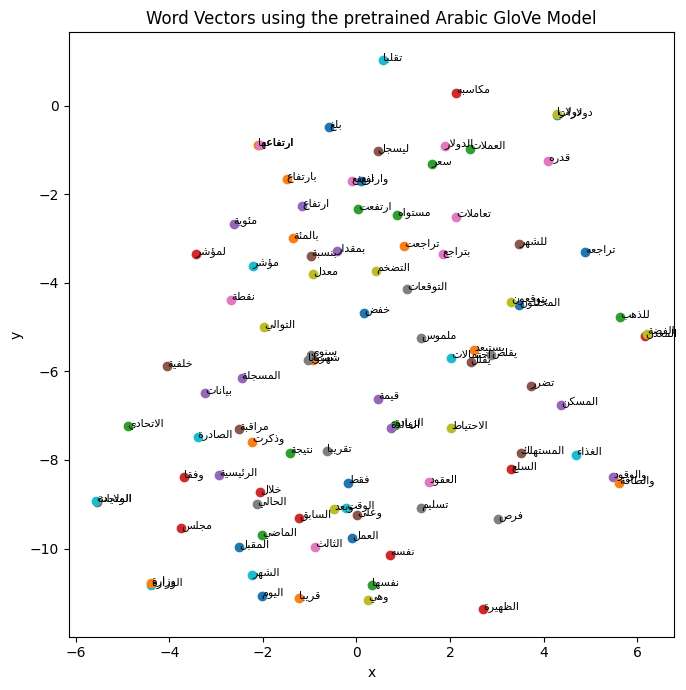

In [49]:
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, n_iter_without_progress=500)
vectors_2d = tsne.fit_transform(np.asarray(glove_vectors))

plt.figure(figsize=(7, 7))
for i, word in enumerate(glove_words):
    xxword = arabic_reshaper.reshape(word) # support arabic letters
    xxartext = get_display(xxword)
    plt.scatter(vectors_2d[i][0], vectors_2d[i][1], marker='o')
    plt.annotate(xxartext, xy=(vectors_2d[i][0], vectors_2d[i][1]), fontsize=8)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Word Vectors using the pretrained Arabic GloVe Model')
plt.tight_layout()
plt.show()

## References
- Kal. (2022, January 4). Word embedding using FastText - KAL - Medium. Medium. https://medium.com/@93Kryptonian/word-embedding-using-fasttext-62beb0209db9
- Educative. One-hot encoding of text data in natural language processing. https://www.educative.io/answers/one-hot-encoding-of-text-data-in-natural-language-processing
- Imran, R. (2023, June 12). Comparing text preprocessing techniques: One-Hot encoding, Bag of Words, TF-IDF, and Word2VEC for sentiment analysis. Medium. https://medium.com/@rayanimran307/comparing-text-preprocessing-techniques-one-hot-encoding-bag-of-words-tf-idf-and-word2vec-for-5850c0c117f1
- Kal. (2022b, January 4). Word embedding using FastText - KAL - Medium. Medium. https://medium.com/@93Kryptonian/word-embedding-using-fasttext-62beb0209db9
- Alshargi. (2024, March 1). Building Skipgram and CBOW Models for Arabic FastText Word Embeddings from Scratch. Medium. https://medium.com/@alshargi.usa/building-skipgram-and-cbow-models-for-arabic-fasttext-word-embeddings-from-scratch-c54860ccd7e7
- Arabic Corpus and Trained GloVe word2vec Vectors : Compiled by: Tarek Eldeeb : Free Download, Borrow, and Streaming : Internet Archive. (2018, June 14). Internet Archive. https://archive.org/details/arabic_corpus
- Alshargi. (2023, July 7). Plotting Arabic Words using Word2Vec Technique: Fixing Right-to-Left Character Appearance Issue. Medium. https://medium.com/@alshargi.usa/plotting-arabic-words-using-word2vec-technique-fixing-right-to-left-character-appearance-issue-5951f17ed592